In [30]:
import figure_traub_eigensources as fte
import numpy as np
import h5py as h5
import scipy
import matplotlib.pyplot as plt
from traub_data_kcsd_column_figure import (prepare_electrodes, prepare_pots,
                                    set_axis)
import os

In [7]:
def plot_eigensources(k, v, start=0, stop=6):
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    index_list = [0, 1, 2, 3, 4, 5, 33, 35]
    fig = plt.figure(figsize=(15, 16))
    for idx, i in enumerate(index_list):
        ax = plt.subplot(241 + idx, aspect='equal')
        a = v[:,  i].reshape(k.estm_x.shape)
        max_a = np.max(np.abs(a))
        levels = np.linspace(-max_a, max_a, 200)
        ax.contourf(k.estm_x, k.estm_y, a[:, :], levels=levels, cmap=plt.cm.bwr)
        ax.set_xlabel('X ($\mu$m)')
        ax.set_ylabel('Y ($\mu$m)')
        ax.set_title(r"$\tilde{K} \cdot{v_{{%(i)d}}}$" % {'i': i+1}, fontsize=20)
        set_axis(ax, letter=letters[idx])
    fig.savefig(os.path.join('Eigensources_' + str(start) + '_' + str(stop)
                             + '.png'), dpi=300)

neuropixel
Done extracellular pots for pop_name pyrRS23
Done extracellular pots for pop_name pyrFRB23
Done extracellular pots for pop_name bask23
Done extracellular pots for pop_name axax23
Done extracellular pots for pop_name LTS23
Done extracellular pots for pop_name spinstel4
Done extracellular pots for pop_name tuftIB5
Done extracellular pots for pop_name tuftRS5
Done extracellular pots for pop_name nontuftRS6
Done extracellular pots for pop_name bask56
Done extracellular pots for pop_name axax56
Done extracellular pots for pop_name LTS56


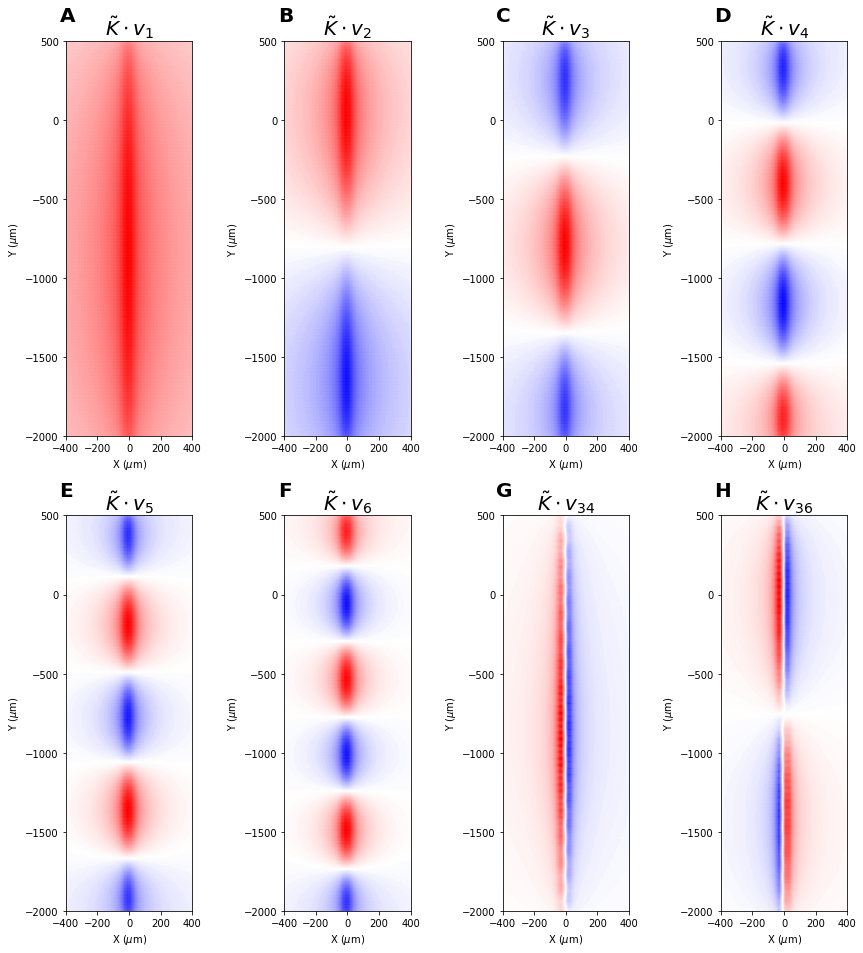

In [8]:
time_pt_interest = 3000
time_pts = 6000  # number of all time frames
num_cmpts = [74, 74, 59, 59, 59, 59, 61, 61, 50, 59, 59, 59]
cell_range = [0, 1000, 1050, 1140, 1230, 1320,
              1560, 2360, 2560, 3060, 3160, 3260, 3360]
num_cells = np.diff(cell_range) / 10  # 10% MODEL
total_cmpts = list(num_cmpts * num_cells)
pop_names = ['pyrRS23', 'pyrFRB23', 'bask23', 'axax23', 'LTS23',
             'spinstel4', 'tuftIB5', 'tuftRS5', 'nontuftRS6',
             'bask56', 'axax56', 'LTS56']

h = h5.File('pulsestimulus10model.h5', 'r')
elec_pos_list, names_list = prepare_electrodes()
pot_np = prepare_pots(elec_pos_list[1], names_list[1], h, pop_names, time_pts)
k, eigenvalues, eigenvectors = fte.do_kcsd_evd(pot_np, elec_pos_list[1][:, :2],
                                            -400, 400, -2000, 500,
                                            R_init=30, n_src_init=5000)
v = np.dot(k.k_interp_cross, eigenvectors)
plot_eigensources(k, v, start=0, stop=6)

In [9]:
import traub_data_kcsd_column_figure as tcf

In [69]:
def make_column_plot(h, pop_names, time_pts, time_pt_interest, elec_pos_list, names_list,
                     all_x, all_y, all_z, all_val, true_csd, true_csd_p,
                     fig_title='Traubs_column'):
    fig = plt.figure(figsize=(15, 16))

    ymin = -2000  # -2150
    ymax = 500  # 550
    xmin = -400  # -450
    xmax = 400  # 450
    ax1 = plt.subplot(241, aspect='equal')
    tcf.plot_all_currents(ax1, xmin, xmax, ymin, ymax, all_x, all_y, all_z,
                      all_val, letter='A')

    ax2 = plt.subplot(242, aspect='equal')
    tcf.plot_csd_slice(ax2, xmin, xmax, ymin, ymax, all_x, all_y, all_z, all_val,
                   letter='B')

    ax3 = plt.subplot(243, aspect='equal')
    tcf.plot_dense_potentials(ax3, h, pop_names, time_pts, time_pt_interest,
                          letter='C', filt=False)
    
    ax4 = plt.subplot(244, aspect='equal')
    xx, yy = np.mgrid[xmin:xmax:complex(0, true_csd.shape[0]),
                      ymin:ymax:complex(0, true_csd.shape[1])]
    tcf.plot_csd_smooth(ax4, xmin, xmax, ymin, ymax, true_csd[:, :],
                    xx, yy, letter='D')

    ax5 = plt.subplot(245, aspect='equal')
    ax6 = plt.subplot(246, aspect='equal')
    ax7 = plt.subplot(247, aspect='equal')
    ax8 = plt.subplot(248, aspect='equal')
    ax_list1 = [ax5, ax6]
    ax_list2 = [ax7, ax8]
    letter_list1 = ['E', 'F']
    letter_list2 = ['G', 'H']
    for i in range(len(elec_pos_list)):
        ele_pos = elec_pos_list[i]
        name = names_list[i]
        pot = prepare_pots(ele_pos, name, h, pop_names, time_pts)
        kcsd, est_pot, x, y, k = tcf.do_kcsd(pot, ele_pos[:, :2], xmin, xmax, ymin, ymax,
                                             n_src_init=5000)
        tcf.plot_csd_smooth(ax_list1[i], xmin, xmax, ymin, ymax, kcsd[:, :, 750], x, y,
                            letter=letter_list1[i], ele_pos=ele_pos)
        
        eigensources = calculate_eigensources(k)
        #print(eigensources.shape)
        projection = csd_into_eigensource_projection(true_csd_p.flatten(), eigensources)
        tcf.plot_csd_smooth(ax_list2[i], xmin, xmax, ymin, ymax, projection.reshape(true_csd_p.shape), x, y,
                        letter=letter_list2[i])

    fig.savefig(os.path.join(fig_title + '.png'), dpi=300)

In [67]:
from imp import reload 
reload(tcf)

<module 'traub_data_kcsd_column_figure' from '/home/mbejtka/Marta/kCSD-python/figures/npx/traub_data_kcsd_column_figure.py'>

In [37]:
800/32

25.0

In [23]:
ymin = -2000  # -2150
ymax = 500  # 550
xmin = -400  # -450
xmax = 400
ele_pos = elec_pos_list[0]
name = names_list[0]
pot = prepare_pots(ele_pos, name, h, pop_names, time_pts)
kcsd, est_pot, x, y, k = tcf.do_kcsd(pot, ele_pos[:, :2], xmin, xmax, ymin, ymax, gdy=25, gdx=25,
                                      n_src_init=5000)

neuroseeker
Done extracellular pots for pop_name pyrRS23
Done extracellular pots for pop_name pyrFRB23
Done extracellular pots for pop_name bask23
Done extracellular pots for pop_name axax23
Done extracellular pots for pop_name LTS23
Done extracellular pots for pop_name spinstel4
Done extracellular pots for pop_name tuftIB5
Done extracellular pots for pop_name tuftRS5
Done extracellular pots for pop_name nontuftRS6
Done extracellular pots for pop_name bask56
Done extracellular pots for pop_name axax56
Done extracellular pots for pop_name LTS56
min lambda 1e-08
max lambda 0.0000
l-curve (all lambda):  30
Best lambda and R =  1e-07 ,  30


In [56]:
kcsd, est_pot, x, y, k = tcf.do_kcsd(pot, ele_pos[:, :2], xmin, xmax, ymin, ymax,
                                      n_src_init=5000)

min lambda 1e-08
max lambda 0.0000
l-curve (all lambda):  30
Best lambda and R =  1e-07 ,  30


In [ ]:
true_csd = tcf.calculate_smoothed_csd(all_x, all_y, all_z, all_val)

pyrRS23

100  / 7400
200  / 7400
300  / 7400
400  / 7400
500  / 7400
600  / 7400
700  / 7400
800  / 7400
900  / 7400
1000  / 7400
1100  / 7400
1200  / 7400
1300  / 7400
1400  / 7400
1500  / 7400
1600  / 7400
1700  / 7400
1800  / 7400
1900  / 7400
2000  / 7400
2100  / 7400
2200  / 7400
2300  / 7400
2400  / 7400
2500  / 7400
2600  / 7400
2700  / 7400
2800  / 7400
2900  / 7400
3000  / 7400
3100  / 7400
3200  / 7400
3300  / 7400
3400  / 7400
3500  / 7400
3600  / 7400
3700  / 7400
3800  / 7400
3900  / 7400
4000  / 7400
4100  / 7400
4200  / 7400
4300  / 7400
4400  / 7400
4500  / 7400
4600  / 7400
4700  / 7400
4800  / 7400
4900  / 7400
5000  / 7400
5100  / 7400
5200  / 7400
5300  / 7400
5400  / 7400
5500  / 7400
5600  / 7400
5700  / 7400
5800  / 7400
5900  / 7400
6000  / 7400
6100  / 7400
6200  / 7400
6300  / 7400
6400  / 7400
6500  / 7400
6600  / 7400
6700  / 7400
6800  / 7400
6900  / 7400
7000  / 7400
7100  / 7400
7200  / 7400
7300  / 7400
7400  / 7400
pyrFRB23

7500  / 370
7600  / 370
7700

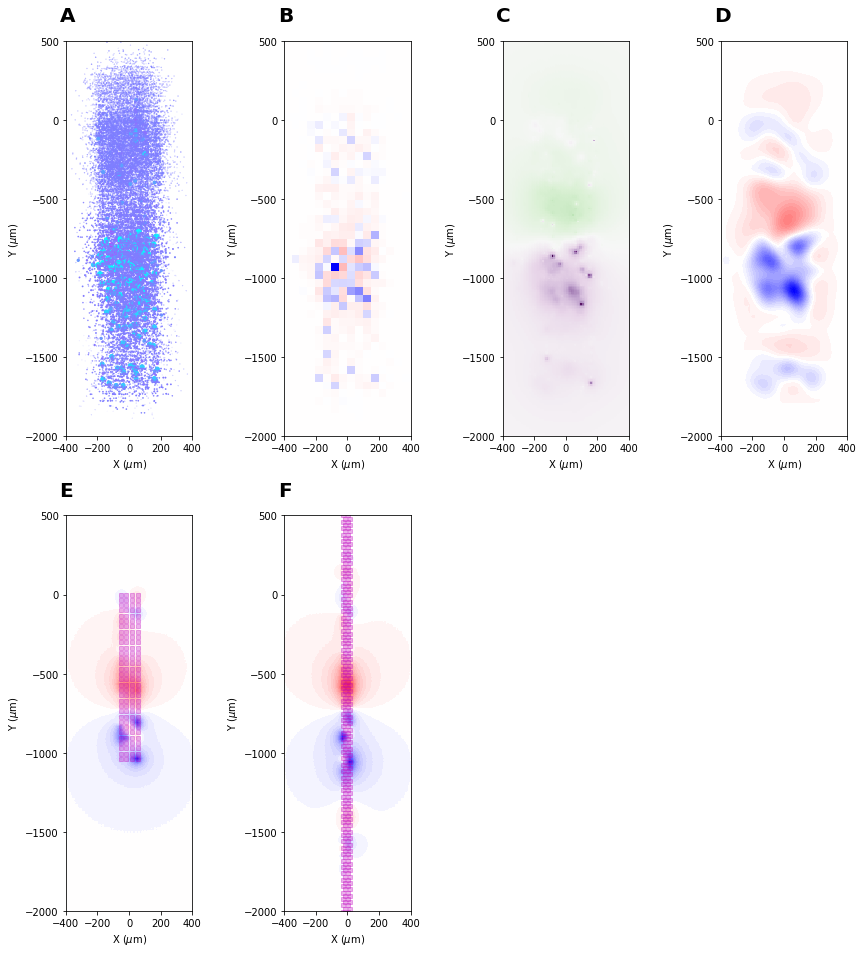

In [14]:
time_pt_interest = 3000
time_pts = 6000  # number of all time frames
num_cmpts = [74, 74, 59, 59, 59, 59, 61, 61, 50, 59, 59, 59]
cell_range = [0, 1000, 1050, 1140, 1230, 1320,
              1560, 2360, 2560, 3060, 3160, 3260, 3360]
num_cells = np.diff(cell_range) / 10  # 10% MODEL
total_cmpts = list(num_cmpts * num_cells)
pop_names = ['pyrRS23', 'pyrFRB23', 'bask23', 'axax23', 'LTS23',
             'spinstel4', 'tuftIB5', 'tuftRS5', 'nontuftRS6',
             'bask56', 'axax56', 'LTS56']

h = h5.File('pulsestimulus10model.h5', 'r')
elec_pos_list, names_list = prepare_electrodes()

### calculate sources values for a single time frame (it may take a while)
all_x, all_y, all_z, all_val = tcf.extract_csd_timepoint(h, pop_names,
                                                      time_pt_interest, 'i')
true_csd2 = tcf.calculate_smoothed_csd(all_x, all_y, all_z, all_val)
make_column_plot(h, pop_names, time_pts, time_pt_interest, elec_pos_list, names_list,
                  all_x, all_y, all_z, all_val, true_csd2, true_csd)

Done extracellular pots for pop_name pyrRS23
Done extracellular pots for pop_name pyrFRB23
Done extracellular pots for pop_name bask23
Done extracellular pots for pop_name axax23
Done extracellular pots for pop_name LTS23
Done extracellular pots for pop_name spinstel4
Done extracellular pots for pop_name tuftIB5
Done extracellular pots for pop_name tuftRS5
Done extracellular pots for pop_name nontuftRS6
Done extracellular pots for pop_name bask56
Done extracellular pots for pop_name axax56
Done extracellular pots for pop_name LTS56
neuroseeker
Done extracellular pots for pop_name pyrRS23
Done extracellular pots for pop_name pyrFRB23
Done extracellular pots for pop_name bask23
Done extracellular pots for pop_name axax23
Done extracellular pots for pop_name LTS23
Done extracellular pots for pop_name spinstel4
Done extracellular pots for pop_name tuftIB5
Done extracellular pots for pop_name tuftRS5
Done extracellular pots for pop_name nontuftRS6
Done extracellular pots for pop_name bask56

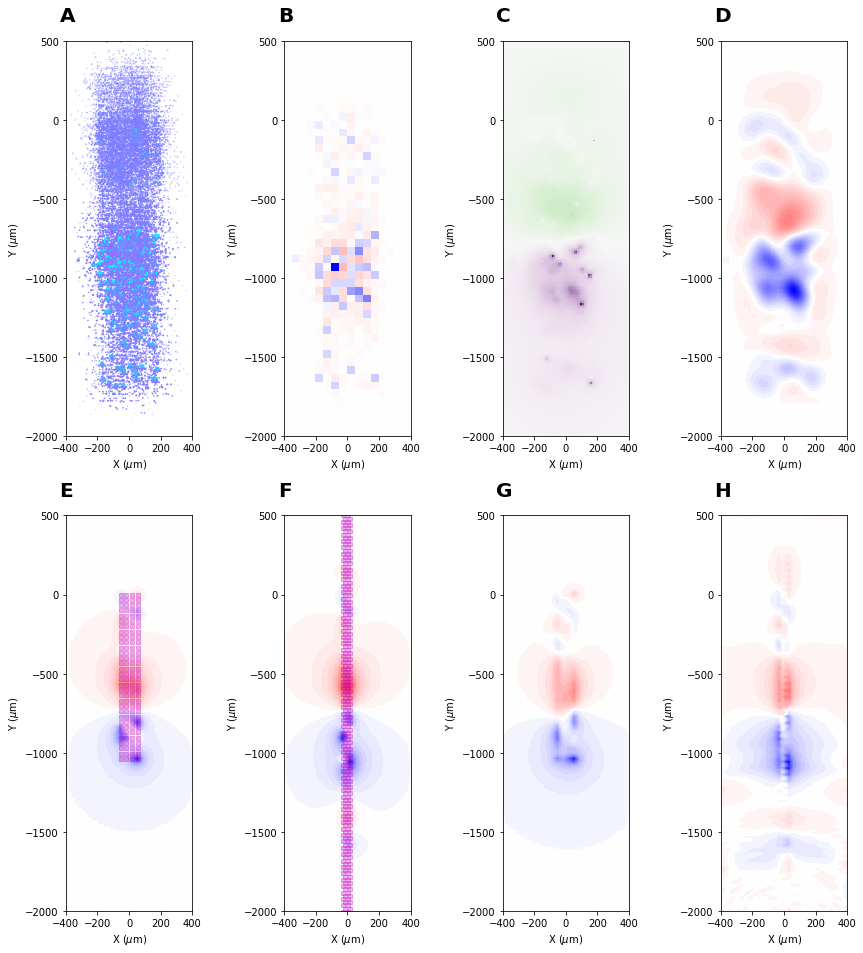

In [70]:
true_csd2 = tcf.calculate_smoothed_csd(all_x, all_y, all_z, all_val)
make_column_plot(h, pop_names, time_pts, time_pt_interest, elec_pos_list, names_list,
                  all_x, all_y, all_z, all_val, true_csd2, true_csd)

In [57]:
true_csd.shape

(200, 625)

In [16]:
def calculate_eigensources(obj):        
    try:
        eigenvalue, eigenvector = np.linalg.eigh(obj.k_pot +
                                                 obj.lambd *
                                                 np.identity
                                                 (obj.k_pot.shape[0]))
        print('lambd: ', obj.lambd)
    except LinAlgError:
        raise LinAlgError('EVD is failing - try moving the electrodes'
                          'slightly')
    idx = eigenvalue.argsort()[::-1]
    eigenvalues = eigenvalue[idx]
    eigenvectors = eigenvector[:, idx]
    eigensources = np.dot(obj.k_interp_cross, eigenvectors)
    #eigensources = eigensources/np.max(abs(eigensources))
    #eigensources = eigensources/np.linalg.norm(eigensources)
    return eigensources

In [52]:
def csd_into_eigensource_projection(csd, eigensources):
    print(eigensources.shape)
    orthn = scipy.linalg.orth(eigensources)
    print('orthn', orthn.shape)
    return np.matmul(np.matmul(csd, orthn), orthn.T)

In [58]:
eigensources = calculate_eigensources(k)

lambd:  1e-07


In [59]:
eigensources.shape

(125000, 128)

In [60]:
k.estm_y.shape

(200, 625)

In [61]:
true_csd.flatten().shape

(125000,)

In [62]:
projection = csd_into_eigensource_projection(true_csd.flatten(), calculate_eigensources(k))

lambd:  1e-07
(125000, 128)
orthn (125000, 128)


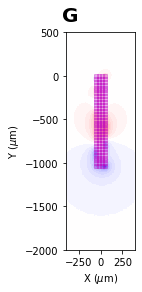

In [63]:
plt.figure()
ax = plt.subplot(111, aspect='equal')
tcf.plot_csd_smooth(ax, xmin, xmax, ymin, ymax, projection.reshape(true_csd.shape), x, y,
                        letter='G', ele_pos=ele_pos)